<a href="https://colab.research.google.com/github/hasibulhshovo/COMP432/blob/main/lab8/lab_8_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Neural Networks

**Focus:** activations → dense layer → tiny MLP → train on XOR → plot results.  
**What you’ll practice:** Forward/backward, BCE with logits, mini‑batch SGD, decision boundaries.


In [1]:
# Import necessary libraries
import math                  # Provides access to mathematical functions like sqrt, sin, cos, etc.
import numpy as np           # Imports NumPy, a powerful library for numerical computations
import matplotlib.pyplot as plt  # Imports Matplotlib's pyplot module for data visualization

# Configure NumPy's print options for better readability
np.set_printoptions(precision=4, suppress=True)
# precision=4 → limits floating-point output to 4 decimal places
# suppress=True → prevents scientific notation (e.g., 1e-5)

# Initialize a random number generator with a fixed seed (0)
RNG = np.random.default_rng(0)
# Using a fixed seed ensures reproducibility of random results

# Building a Tiny MLP Classifier from Scratch

## What you're building (and why)

We'll assemble the minimum pieces needed for a tiny MLP classifier and train it end-to-end:

* **Activations**: `sigmoid` and `ReLU` plus their derivatives w.r.t. the pre-activation $z$. Nonlinearities let stacked layers model non-linear decision boundaries (e.g., XOR).
* **Dense (fully-connected) layer**: forward pass $Z = XW + b$, then $A = f(Z)$. We'll store cached values for backprop.
* **Loss**: Binary cross-entropy with logits for binary classification. Using "with logits" is numerically stable and gives a clean gradient.
* **Backprop**: given upstream gradient $\frac{dL}{dA}$, compute $\frac{dL}{dZ}$, then parameter grads $(dW, db)$ and the input grad $dX$.
* **Initialization & updates**: weights scaled by $\frac{1}{\sqrt{\text{in\_features}}}$ for healthy signal flow; in-place parameter updates (`P[...] = ...`) to keep references intact.

---

## Shapes and broadcasting

* $X \in \mathbb{R}^{N \times D}$, $W \in \mathbb{R}^{D \times H}$, $b \in \mathbb{R}^H$ (broadcast over batch), $Z, A \in \mathbb{R}^{N \times H}$
* For binary outputs, logits often have shape $(N, 1)$; you'll frequently `reshape(-1)` for loss calculations.

---

## Formulas:

### Forward
$$Z = XW + b, \quad A = f(Z)$$

### Activation derivatives
$$\sigma(z) = \frac{1}{1 + e^{-z}}, \quad \sigma'(z) = \sigma(z)(1 - \sigma(z))$$

$$\text{ReLU}(z) = \max(0, z), \quad \text{ReLU}'(z) = \mathbb{1}[z > 0]$$

### Backprop through layer (with elementwise $\odot$)
$$\frac{dL}{dZ} = \frac{dL}{dA} \odot f'(Z), \quad \frac{dL}{dW} = \frac{1}{N} X^\top \frac{dL}{dZ}, \quad \frac{dL}{db} = \text{mean}_{\text{batch}}(\frac{dL}{dZ}), \quad \frac{dL}{dX} = \frac{dL}{dZ} W^\top$$

### BCE with logits (stable) for $z \in \mathbb{R}^N$, $y \in \{0,1\}^N$
$$\text{loss} = \frac{1}{N} \sum_i \left( \max(z_i, 0) - z_i y_i + \log(1 + e^{-|z_i|}) \right)$$

$$\frac{\partial \text{loss}}{\partial z_i} = \frac{\sigma(z_i) - y_i}{N}$$

---

## Why "with logits"? (stability)

Computing BCE on probabilities can under/overflow when $p$ is near $0$ or $1$. The logits formulation keeps math stable and yields a simple gradient $\sigma(z) - y$.

---

## Common pitfalls to avoid

* **Mixing up derivatives** w.r.t. $z$ vs w.r.t. $a = f(z)$. In backprop we need $f'(z)$.
* **Forgetting bias broadcasting**: $b$ should be shape `(H,)`, not `(1, H)`.
* **Rebinding vs in-place updates**: use `P[...] = ...` so the model still references the same arrays.
* **For binary tasks**, don't apply `sigmoid` inside the layer if your loss already expects logits.

---

## Sanity checks you should keep in mind...

* After `forward`, verify shapes: `Z.shape == A.shape == (N, H)`.
* After `backward`, check: `dW.shape == W.shape`, `db.shape == b.shape`, `dX.shape == X.shape`.
* Loss should decrease over epochs; accuracy should rise above chance on XOR.


In [2]:
# --- Activation functions ---
def sigmoid(z):
    # Ensure input is a NumPy array with float64 precision
    z = np.asarray(z, dtype=np.float64)
    out = np.empty_like(z)  # Create an empty array of the same shape as z

    # To maintain numerical stability, handle positive and negative values separately
    pos = z >= 0
    neg = ~pos

    # For positive values: use the standard sigmoid formula
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))

    # For negative values: use an equivalent expression to avoid overflow
    ez = np.exp(z[neg])
    out[neg] = ez / (1.0 + ez)

    return out


def d_sigmoid(z):
    # Derivative of the sigmoid function: s * (1 - s)
    s = sigmoid(z)
    return s * (1.0 - s)


def relu(z):
    # ReLU activation: f(z) = max(0, z)
    z = np.asarray(z)
    return np.maximum(0, z)


def d_relu(z):
    # Derivative of ReLU: 1 if z > 0, else 0
    z = np.asarray(z)
    return (z > 0).astype(z.dtype)


# --- Fully Connected (Dense) Layer ---
class Dense:
    def __init__(self, in_features, out_features, activation='relu', rng=RNG):
        # Weight initialization: small random numbers scaled by 1/sqrt(in_features)
        self.W = rng.normal(scale=1 / np.sqrt(in_features),
                            size=(in_features, out_features)).astype(np.float32)
        # Bias initialization: zeros
        self.b = np.zeros((out_features,), dtype=np.float32)

        # Store activation function type ('relu', 'sigmoid', etc.)
        self.act = activation

        # Cache for intermediate results (used in backprop)
        self.cache = None

        # Placeholders for gradients
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

    def _act(self, Z):
        # Apply activation function based on user selection
        if self.act == 'relu':
            return relu(Z)
        if self.act == 'sigmoid':
            return sigmoid(Z)
        if self.act in (None, 'identity'):
            return Z
        raise ValueError("unknown activation")

    def _d_act(self, Z):
        # Compute derivative of activation function for backpropagation
        if self.act == 'relu':
            return d_relu(Z)
        if self.act == 'sigmoid':
            return d_sigmoid(Z)
        if self.act in (None, 'identity'):
            return np.ones_like(Z)
        raise ValueError("unknown activation")

    def forward(self, X):
        # Forward pass: compute linear combination and apply activation
        Z = X @ self.W + self.b      # Linear transformation
        A = self._act(Z)             # Apply activation
        self.cache = (X, Z, A)       # Store for backward pass
        return A

    def backward(self, dA):
        # Backward pass: compute gradients w.r.t. inputs, weights, and biases
        X, Z, A = self.cache
        dZ = dA * self._d_act(Z)            # Gradient through activation
        self.dW = X.T @ dZ / X.shape[0]     # Gradient w.r.t. weights (averaged)
        self.db = dZ.mean(axis=0)           # Gradient w.r.t. biases (averaged)
        dX = dZ @ self.W.T                  # Gradient w.r.t. input
        return dX


# --- Binary Cross Entropy Loss with Logits ---
def bce_with_logits(z, y):
    # Converts inputs to NumPy arrays and ensures correct shape
    z = np.asarray(z).reshape(-1)
    y = np.asarray(y).reshape(-1).astype(np.float64)

    # Numerically stable binary cross-entropy loss
    # loss = max(z, 0) - z*y + log(1 + exp(-|z|))
    loss = (np.maximum(z, 0.) - z * y + np.log1p(np.exp(-np.abs(z)))).mean()

    # Compute the sigmoid of z for gradient calculation
    sig = 1.0 / (1.0 + np.exp(-z))

    # Gradient of BCE loss w.r.t. logits z
    dz = (sig - y) / z.shape[0]

    return float(loss), dz


# --- Tiny MLP (2-layer neural network) ---
class MLP2:
    def __init__(self, in_dim, hidden, out_dim, rng=RNG):
        # First (hidden) dense layer with ReLU activation
        self.h = Dense(in_dim, hidden, activation='relu', rng=rng)
        # Second (output) dense layer with linear (identity) activation
        self.o = Dense(hidden, out_dim, activation='identity', rng=rng)

    def forward(self, X):
        # Forward pass through both layers
        H = self.h.forward(X)   # Hidden layer output
        Z = self.o.forward(H)   # Output layer (logits)
        return Z

    def backward(self, dZ):
        # Backward pass through both layers
        dH = self.o.backward(dZ)   # Backprop through output layer
        _ = self.h.backward(dH)    # Backprop through hidden layer
        return _

    def params_and_grads(self):
        # Generator yielding parameters and their corresponding gradients
        yield self.h.W, self.h.dW
        yield self.h.b, self.h.db
        yield self.o.W, self.o.dW
        yield self.o.b, self.o.db

## 2) Data: XOR (non-linearly separable)

### What is XOR and why does it matter?

**XOR (exclusive OR)** is a classic problem in neural network history. It's the simplest function that cannot be learned by a single linear classifier (like logistic regression). This is what makes it perfect for testing a simple MLP:

| $x_1$ | $x_2$ | XOR output |
|-------|-------|------------|
| 0     | 0     | 0          |
| 0     | 1     | 1          |
| 1     | 0     | 1          |
| 1     | 1     | 0          |

**Why it's non-linearly separable**: Try drawing a single straight line to separate the 0s from the 1s - you can't! You need a curved decision boundary, which requires:
1. Multiple layers (depth)
2. Non-linear activation functions (ReLU, sigmoid, etc.)

---

### Generating the XOR dataset

We'll create a dataset with:
- **Input features**: 2D points $(x_1, x_2)$ where each coordinate is sampled from the appropriate class region
- **Labels**: Binary (0 or 1) based on the XOR logic
- **Noise**: Optional Gaussian noise to make the problem more realistic

#### Data generation strategy:

For **class 0** (XOR = 0):
- Sample points near $(0, 0)$ and $(1, 1)$

For **class 1** (XOR = 1):
- Sample points near $(0, 1)$ and $(1, 0)$


In [3]:
def make_xor(n_per_quad=60, noise=0.2, rng=RNG):
    """
    Generates a 2D XOR dataset.

    Parameters:
        n_per_quad (int): Number of points per quadrant.
        noise (float): Standard deviation of Gaussian noise added to each point.
        rng (np.random.Generator): Random number generator for reproducibility.

    Returns:
        X (np.ndarray): Feature matrix of shape (4 * n_per_quad, 2)
        y (np.ndarray): Binary labels (0 or 1) for XOR classification.
    """
    # Define four cluster centers (quadrants)
    centers = np.array([[1, 1], [1, -1], [-1, 1], [-1, -1]], dtype=float)

    # Initialize empty lists to store points and labels
    X = []
    y = []

    # Generate data around each center
    for c in centers:
        # Add Gaussian noise to each cluster center to create spread-out points
        pts = c + rng.normal(scale=noise, size=(n_per_quad, 2))
        X.append(pts)

        # XOR labeling rule:
        # If the signs of x and y differ → class 1, otherwise → class 0
        y += [1 if (c[0] * c[1] < 0) else 0] * n_per_quad

    # Combine all points into a single NumPy array
    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.int64)
    return X, y

# Generate XOR dataset (50 points per quadrant, with 0.2 noise)
X, y = make_xor(50, 0.2)

# Create a permutation of indices to shuffle the dataset
perm = np.arange(X.shape[0])
RNG.shuffle(perm)

# Shuffle both features and labels in unison
X, y = X[perm], y[perm]

# Split the dataset into training (70%) and validation (30%) sets
split = int(0.7 * len(X))
X_tr, y_tr = X[:split], y[:split]  # Training set
X_val, y_val = X[split:], y[split:]  # Validation set

# Display dataset info: shape and label distribution
X.shape, np.bincount(y)

((200, 2), array([100, 100]))

## 3) Train a tiny MLP with mini-batch SGD

### Architecture overview: 2 → 8 → 1

This simple architecture is perfect for XOR and demonstrates all key MLP concepts.

- **Input: 2 neurons**: matches XOR features $(x_1, x_2)$
- **Hidden: 8 neurons**: enough capacity to learn XOR decision boundary (even 2-4 would work!)
- **Output: 1 neuron**: binary classification (outputs raw logit, not probability)
- **Total parameters**: $(2 \times 8 + 8) + (8 \times 1 + 1) = 16 + 8 + 8 + 1 = 33$ parameters

**Layer-by-layer forward pass:**
1. $Z_1 = X W_1 + b_1$ where $Z_1 \in \mathbb{R}^{N \times 8}$
2. $A_1 = \text{ReLU}(Z_1)$
3. $Z_2 = A_1 W_2 + b_2$ where $Z_2 \in \mathbb{R}^{N \times 1}$ (logits)
4. $\text{Loss} = \text{BCE}(Z_2, y)$

---

### Mini-batch Stochastic Gradient Descent (SGD)

Instead of computing gradients on the entire dataset (batch GD) or single examples (SGD), we use **mini-batches**:

| Method | Batch Size | Pros | Cons |
|--------|-----------|------|------|
| **Batch GD** | Full dataset (N) | Stable, smooth convergence | Slow, memory intensive |
| **Stochastic GD** | 1 sample | Fast updates, escapes local minima | Noisy, unstable |
| **Mini-batch SGD** | 16-256 samples | Balanced speed & stability | Requires tuning |

In [4]:
# --- Stochastic Gradient Descent Optimizer ---
class SGD:
    def __init__(self, lr=0.2, weight_decay=0.0):
        """
        Simple implementation of Stochastic Gradient Descent (SGD) with optional L2 weight decay.

        Parameters:
            lr (float): Learning rate.
            weight_decay (float): L2 regularization coefficient (default: 0).
        """
        self.lr = lr                 # Step size for parameter updates
        self.wd = weight_decay       # Weight decay (L2 regularization)

    def step(self, params_and_grads):
        """
        Perform one optimization step over all parameters.

        Parameters:
            params_and_grads: Iterable of (parameter, gradient) pairs.
        """
        for P, dP in params_and_grads:
            # Apply L2 regularization if weight decay > 0
            # (Add weight penalty proportional to the current weights)
            if self.wd > 0 and P.ndim >= 1:
                dP = dP + self.wd * P

            # Parameter update rule:
            # new_param = old_param - learning_rate * gradient
            # P[...] updates the array in-place (for all elements)
            P[...] = P - self.lr * dP  # Update all elements of P


# --- Mini-batch training loop ---
def train_minibatch(model, X, y, Xv, yv, epochs=300, batch_size=32, lr=0.2, wd=0.0, seed=0):
    """
    Trains a neural network model using mini-batch gradient descent.

    Parameters:
        model: Neural network model (must implement forward, backward, and params_and_grads()).
        X, y: Training data and labels.
        Xv, yv: Validation data and labels.
        epochs (int): Number of training iterations.
        batch_size (int): Number of samples per training batch.
        lr (float): Learning rate.
        wd (float): Weight decay (L2 regularization strength).
        seed (int): Random seed for reproducibility.

    Returns:
        hist (dict): Training history (losses and accuracies for both train and validation).
    """
    rng = np.random.default_rng(seed)       # Initialize random number generator
    opt = SGD(lr=lr, weight_decay=wd)       # Create SGD optimizer
    hist = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}  # Track metrics

    def acc(logits, y):
        """Compute binary classification accuracy."""
        # Convert logits → probabilities using sigmoid
        p = 1 / (1 + np.exp(-logits.reshape(-1)))
        # Convert probabilities → class predictions (0 or 1)
        preds = (p >= 0.5).astype(int)
        # Compute accuracy (fraction of correct predictions)
        return (preds == y).mean()

    # --- Main training loop ---
    for ep in range(epochs):
        # Shuffle training data indices for each epoch
        idx = np.arange(len(X))
        rng.shuffle(idx)

        # Mini-batch iteration
        for i in range(0, len(idx), batch_size):
            b = idx[i:i + batch_size]          # Batch indices
            xb, yb = X[b], y[b]                # Batch data and labels

            # --- Forward pass ---
            logits = model.forward(xb).reshape(-1)

            # --- Compute loss and gradient ---
            loss, dZ = bce_with_logits(logits, yb)

            # --- Backward pass ---
            model.backward(dZ.reshape(-1, 1))

            # --- Update parameters using optimizer ---
            opt.step(model.params_and_grads())

        # --- Compute training and validation metrics at the end of epoch ---
        tr_logits = model.forward(X).reshape(-1)
        tr_loss, _ = bce_with_logits(tr_logits, y)

        va_logits = model.forward(Xv).reshape(-1)
        va_loss, _ = bce_with_logits(va_logits, yv)

        # Record metrics
        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(va_loss)
        hist["train_acc"].append(acc(tr_logits, y))
        hist["val_acc"].append(acc(va_logits, yv))

    return hist


# --- Model creation and training ---
# Define a simple 2-layer MLP (2 input features → 8 hidden neurons → 1 output neuron)
model = MLP2(2, 8, 1)

# Train the model on the XOR dataset
hist = train_minibatch(
    model, X_tr, y_tr, X_val, y_val,
    epochs=300, batch_size=32, lr=0.2, wd=0.0
)

# Print final accuracy
print("Final acc — train: %.3f | val: %.3f" % (hist["train_acc"][-1], hist["val_acc"][-1]))

Final acc — train: 0.971 | val: 0.950


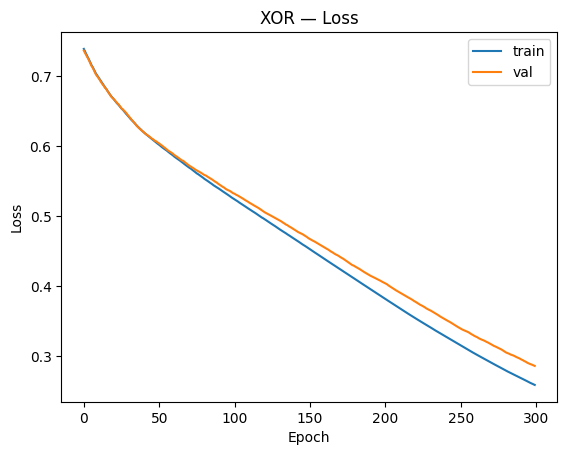

In [5]:
# --- Plot training and validation loss curves ---

# Create a new figure for the loss plot
plt.figure()

# Plot training loss over epochs
plt.plot(hist["train_loss"], label="train")

# Plot validation loss over epochs
plt.plot(hist["val_loss"], label="val")

# Label the axes
plt.xlabel("Epoch")   # X-axis: number of training epochs
plt.ylabel("Loss")    # Y-axis: average binary cross-entropy loss

# Add a title to describe the plot
plt.title("XOR — Loss")

# Display the legend to distinguish train vs. validation curves
plt.legend()

# Render the plot on screen
plt.show()

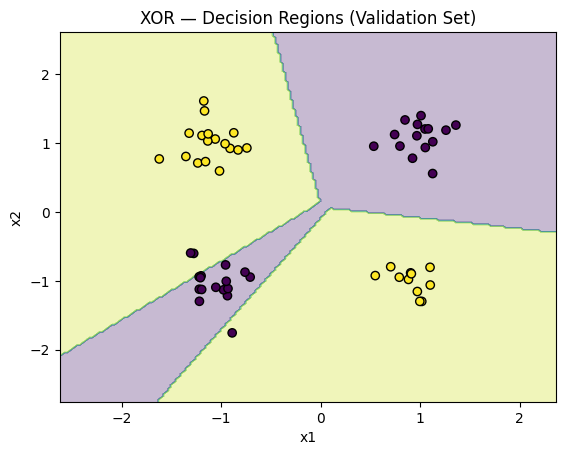

In [6]:
# --- Visualize the decision boundary for the trained XOR classifier ---

# Create a mesh grid (xx, yy) covering the range of input features
# Each point in this grid will be used to evaluate the model’s prediction
xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 200),  # Range for feature x1
    np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 200)   # Range for feature x2
)

# Combine grid coordinates into a (N, 2) array of all (x1, x2) points
grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)

# Compute model outputs (logits) for every grid point
logits = model.forward(grid).reshape(-1)

# Apply sigmoid to convert logits to probabilities, then threshold at 0.5 to get class predictions
pred = (1 / (1 + np.exp(-logits)) >= 0.5).astype(int).reshape(xx.shape)

# --- Plot the decision regions and validation data ---

plt.figure()

# Plot filled contour map: colors show the predicted class regions (0 or 1)
plt.contourf(xx, yy, pred, alpha=0.3)

# Overlay the actual validation points, colored by true label
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, edgecolors='k')

# Add title and axis labels
plt.title("XOR — Decision Regions (Validation Set)")
plt.xlabel("x1")
plt.ylabel("x2")

# Display the decision boundary plot
plt.show()


## 4) Quick reflections
1. Why does XOR require a hidden (non‑linear) layer?  
2. In `Dense.backward`, explain the shapes of `dW`, `db`, and `dX`.  
3. What symptoms in the loss/accuracy would suggest underfitting vs. overfitting here?
